In [1]:
import numpy as np
import pandas as pd
import os
import glob
import networkx
from nltk import edit_distance
from itertools import combinations

In [2]:
satcs = glob.glob('*_2/*')
satc_ = pd.read_csv('tabula_sapiens_10x_unpacked_2/TSP_10x_gap_0_unpublished_SPLIT_TSP21_SPLIT_BoneMarrowbin88.satc_unpacked',sep='\t',header=None)
satc_ = satc_[satc_[4]>1]
satc = satc_[satc_[2]=='AGAAGAACTAATGTTAGTATAAGTAAC']
satc_.shape, satc_[2].value_counts().reset_index()

((220244, 5),
                             index     2
 0     AGAAGAACTAATGTTAGTATAAGTAAC  4578
 1     GAGCCTGGTGATAGCTGGTTGTCCAAG  4219
 2     CGCATAAGCCTGCGTCAGATTAAAACA  4179
 3     CTCCTCACACCCAATTGGACCAATCTA  3829
 4     ATTGGACCAATCTATCACCCTATAGAA  3807
 ...                           ...   ...
 1321  TGGAATTCTTTGTCTTTGACTTTTGAC     2
 1322  AGCGTGGCCGTTGGCTGCCTCGCACAG     2
 1323  CCGACGGCACCTACGGCTCAACATTTT     2
 1324  GCTCATATGCGAGCGCTAATTCTGTGG     2
 1325  CTCAGGGAGTGCATCCGCCCCAACCCT     2
 
 [1326 rows x 2 columns])

In [3]:
satc = satc.rename(columns={1:'sample',2:'anchor',3:'target',4:'count'})
satc = satc[['sample','anchor','target','count']]

### Define configurations for a target-centered graph. 


graphName : (anchor, class)

nodeType : "target" 

nodeFeatures : [ "seqComp" , "sampleFraction" ]

edgeFeatures : [ "targetHamming" , "targetLevenshtein" , "corrSampleFractions" , 
                 "corrBoolSampleFractions" , "naiveMSA" ]

connectedness: [ "full" , "sampleCorrelated" , "toleratedHamming_"+{float} , "toleratedLevenshtein_"+{float} ] 



### Define configurations for a sample-centered graph. 

graphName : (anchor, class)

nodeType : "sample" 

nodeFeatures : [ "maskedSeqComp" , "sampleFraction" ]

edgeFeatures : [ "fullTargetHamming" , "fullTargetLevenshtein" ,"aggTargetHamming" , "aggTargetLevenshtein" ,
                 "corrSampleFractions" ,  "corrBoolSampleFractions" , "naiveMSA" ]

connectedness: [ "full" , "sampleCorrelated" , "toleratedMeanHamming_"+{float} , "toleratedMeanLevenshtein_"+{float} ] 
    

In [227]:
def node_featurization(data, nodeType, nodeFeatures, ordering):
    
    nodeFeatureDict = dict()
    
    if 'seqComp' in nodeFeatures:
        
        nodeFeatureDict['seqComp'] = dict()
        
        for target in data['target'].unique():
        
            seq = np.array(list(target))
            mat = np.zeros(shape=(4,len(seq)))
            mat[0] = np.array([1*(seq == 'A')])
            mat[1] = np.array([1*(seq == 'C')])
            mat[2] = np.array([1*(seq == 'G')])
            mat[3] = np.array([1*(seq == 'T')])
            nodeFeatureDict['seqComp'][target] = mat
            
    if 'sampleFraction' in nodeFeatures:
    
        nodeFeatureDict['sampleFraction'] = dict()
        
        if nodeType == 'sample':
            
            full = pd.DataFrame({'target':ordering})
            
            for sample in data['sample'].unique():
                
                this_full = full.merge(data[data['sample']==sample][['sample','target','count']],how='left').fillna(0)
                nodeFeatureDict['sampleFraction'][sample] = np.array(this_full['count'] / this_full['count'].sum())
        
        if nodeType == 'target': 
          
            full = pd.DataFrame({'sample':ordering})
            
            for target in data['target'].unique():
                
                this_full = full.merge(data[data['target']==target][['sample','target','count']],how='left').fillna(0)
                nodeFeatureDict['sampleFraction'][target] = np.array(this_full['count'] / this_full['count'].sum())
             

    if 'maskedSeqComp' in nodeFeatures:
     
        if 'seqComp' in nodeFeatures:
            internalFeatureDict = nodeFeatureDict
        
        else:
            internalFeatureDict = dict()
        
        for target in data['target'].unique():
         
            seq = np.array(list(target))
            mat = np.zeros(shape=(4,len(seq)))
            mat[0] = np.array([1*(seq == 'A')])
            mat[1] = np.array([1*(seq == 'C')])
            mat[2] = np.array([1*(seq == 'G')])
            mat[3] = np.array([1*(seq == 'T')])
            internalFeatureDict['seqComp'][target] = mat
        
        for sample in data['sample'].unique():
               
            nodeFeatureDict['maskedSeqComp'][sample] = np.zeros(shape=(len(ordering),4,len(ordering[0])))
            sample_targets = set(data[data['sample']==sample]['target'].unique())
            ordering_set = set(ordering)
            
            for index in range(len(ordering)):
                
                verbose = ordering[index]
                
                if verbose in sample_targets:
                    
                    nodeFeatureDict['maskedSeqComp'][sample][index] = internalFeatureDict['seqComp'][verbose]
        
    return nodeFeatureDict

In [228]:
def pairwise_similarities(values, function):
    
    distanceMatrix = np.zeros(shape=(len(values),len(values)))

    for i in range(len(values)): 

        for j in range(len(values)):

            distanceMatrix[i][j] = function(values[i], values[j])
    
    return distanceMatrix


def hamming_distance(seq1, seq2):
    
    return sum(c1 != c2 for c1, c2 in zip(seq1, seq2))


def correlation_matrix(vectorDict, keys, isBoolMasked):
    
    correlationMatrix = np.zeros(shape=(len(keys),len(keys)))
    setList = []

    if not isBoolMasked:
    
        for i in range(len(keys)): 

            for j in range(len(keys)): 
            
                corr = np.dot(vectorDict[keys[i]], vectorDict[keys[j]])
                correlationMatrix[i][j] = corr
                
                if corr > 0: 
                    
                    s = set([keys[i],keys[j]])
                    
                    if len(s) > 1 and s not in setList:
                        
                        setList.append(s)
        
        return correlationMatrix, [tuple(i) for i in setList]
    
    if isBoolMasked is True: 
        
        for i in range(len(keys)): 
            
            for j in range(len(keys)): 
                
                correlationMatrix[i][j] = np.dot(1*(vectorDict[keys[i]]>0), 1*(vectorDict[keys[j]]>0))

        return correlationMatrix

In [229]:
def edgeFeatures(data, nodeType, edges, edgeFeatureList, nodeOrdering, ordering, hamDistanceMatrix, levDistanceMatrix, correlationMatrix, boolCorrelationMatrix):    
    
    edgeFeatureDict = dict()
        
    for edge in edges: 

        i, j = np.nonzero(nodeOrdering==edge[0])[0][0], np.nonzero(nodeOrdering==edge[1])[0][0]
        edgeFeatureDict[edge] = dict()

        if 'corrBoolSampleFractions' in edgeFeatureList:
            
            edgeFeatureDict[edge]['corrBoolSampleFractions'] = boolCorrelationMatrix[i][j]
        
        if 'corrSampleFractions' in edgeFeatureList:
            
            edgeFeatureDict[edge]['corrSampleFractions'] = correlationMatrix[i][j]
            
        if 'targetHamming' in edgeFeatureList:
            
            edgeFeatureDict[edge]['targetHamming'] = hamDistanceMatrix[i][j]
            
        if 'targetLevenshtein' in edgeFeatureList:
            
            edgeFeatureDict[edge]['targetLevenshtein'] = levDistanceMatrix[i][j]
            
    return edgeFeatureDict

In [230]:
def construct_graph(data, graphName, nodeType, nodeFeatures, edgeFeatureList, connectedness, ordering):
    
    output_dict = dict()
    
    output_dict['nodeFeatures'] = node_featurization(data, nodeType, nodeFeatures, ordering)
    
    if nodeType == 'target': 
        
        node_value_arr = data['target'].unique()
        
    if nodeType == 'sample': 
        
        node_value_arr = data['sample'].unique()
        
    ####
    ####
    ####
    #### If needed, precompute all pairwise Hamming and/or Levenshtein distances.
        
    hamDistanceMatrix = 0
    
    if 'Hamming' in ''.join(edgeFeatureList) or ''.join(connectedness):
        
        if nodeType == 'target': 
            
            hamDistanceMatrix = pairwise_similarities(node_value_arr, hamming_distance)
        
        if nodeType == 'sample': 
            
            hamDistanceMatrix = pairwise_similarities(ordering, hamming_distance)
            
    levDistanceMatrix = 0
        
    if 'Levenshtein' in ''.join(edgeFeatureList) or ''.join(connectedness):
        
        if nodeType == 'target': 
            
            levDistanceMatrix = pairwise_similarities(node_value_arr, edit_distance)
            
        if nodeType == 'sample': 
            
            levDistanceMatrix = pairwise_similarities(ordering, edit_distance)
            
    ####
    ####
    ####
    #### Define edge sets prior to constructing edge features. 
    
    if 'full' in connectedness: 
        
        output_dict['edges'] = list(combinations(node_value_arr, 2))
        
    correlationMatrix = 0
    
    if 'sampleCorrelated' in connectedness or 'corr' in ''.join(edgeFeatureList): 
        
        correlationMatrix, output_dict['edges'] = correlation_matrix(output_dict['nodeFeatures']['sampleFraction'], node_value_arr, False)
        
    boolCorrelationMatrix = 0
    
    if 'Bool' in ''.join(edgeFeatureList):
        
        boolCorrelationMatrix = correlation_matrix(output_dict['nodeFeatures']['sampleFraction'], node_value_arr, True)   
        
    output_dict['edgeFeatures'] = edgeFeatures(data, nodeType, output_dict['edges'], edgeFeatureList, node_value_arr, ordering, hamDistanceMatrix, levDistanceMatrix, correlationMatrix, boolCorrelationMatrix)
            
    return output_dict

In [231]:
a = construct_graph(select, 'test', 'target', ['seqComp','sampleFraction'], ["targetHamming" , "targetLevenshtein" , "corrSampleFractions" , "corrBoolSampleFractions" ], ['sampleCorrelated'],satc['sample'].unique())


In [239]:
satc.to_csv('vibrio_satc/satc.tsv',sep='\t',index=None)

In [243]:
import torch
from torch_geometric.data import Data

In [298]:
list(v[v['anchor']=='AAAAACCTAGTGAGGCAATAACTCAGA']['class'])[0]

'unclassified'

In [299]:
## Define one sample ordering for all anchors. 
sample_ord = satc['sample'].unique()
store_dict_and_data = dict()

for anchor in satc['anchor'].unique():

    label = list(v[v['anchor']==anchor]['class'])[0]
    select = satc[satc['anchor']==anchor]
    a = construct_graph(select, 'test', 'target', ['seqComp','sampleFraction'], ["targetHamming" , "targetLevenshtein" , "corrSampleFractions" , "corrBoolSampleFractions" ], ['sampleCorrelated'],satc['sample'].unique())

    ## Define one target ordering for this anchor.
    ## The index of each entry defines its node ID. 
    target_ord = np.array(list(a['nodeFeatures']['seqComp'].keys()))

    ## Extract node features. 
    nodeFeatureList = []
    for target in target_ord:
        nodeFeatureList.append(list(np.append(a['nodeFeatures']['seqComp'][target].flatten(),\
        a['nodeFeatures']['sampleFraction'][target])))

    ## Define the tensor corresponding to node features. 
    x = torch.tensor(nodeFeatureList)

    ## Extract edges and edge features. 
    edgeFeatureListOrder = []
    edge_index_top, edge_index_bot = [], []
    edgeFeaturesVector = []
    for edge in a['edges']:
        i, j = np.nonzero(target_ord==edge[0])[0][0], np.nonzero(target_ord==edge[1])[0][0]
        edge_index_top.append(i)
        edge_index_top.append(j)
        edge_index_bot.append(j)
        edge_index_bot.append(i)
        if not len(edgeFeatureListOrder):
            edgeFeatureListOrder = list(a['edgeFeatures'][edge].keys())
        extractedFeatures = []
        for eF in edgeFeatureListOrder:
            extractedFeatures.append(a['edgeFeatures'][edge][eF])
        edgeFeaturesVector.append(extractedFeatures) 
        edgeFeaturesVector.append(extractedFeatures)

    ## Define the tensors corresponding to edges and edge features. 
    edge_attributes = torch.tensor(edgeFeaturesVector)
    edge_index = torch.tensor([edge_index_top,edge_index_bot])

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attributes, y=label)

    store_dict_and_data[anchor] = label, a, data
    

In [301]:
len(store_dict_and_data.keys())

3428

In [ ]:
## Given the set of anchors, take 80 percent of CRISPR and MGEs into training;  
## take 20% of CRISPR and MGEs into test. 


In [314]:
cri = v[v['class']=='CRISPR']
mge = v[v['class']=='MGE']
unc = v[v['class']=='unclassified']
v.groupby(['class'])['anchor'].nunique()

class
CRISPR            67
MGE              119
unclassified    3242
Name: anchor, dtype: int64

#### Training split; CRISPR, MGE, unclassified.

In [694]:
int((0.8*67)//1), int((0.8*119)//1), int(((67+119)/2)//1)

(53, 95, 93)

In [696]:
53 / (53 + 95 + 93), 95 / (53 + 95 + 93), 93 / (53 + 95 + 93)

(0.21991701244813278, 0.3941908713692946, 0.38589211618257263)

#### Testing split; CRISPR, MGE, unclassified.

In [698]:
(14, 24, 42)

(14, 24, 42)

In [699]:
14 / (14 + 24 + 42 ), 24 / (14 + 24 + 42 ), 42 / (14 + 24 + 42 )


(0.175, 0.3, 0.525)

In [318]:
train_cri_anchs = np.random.choice(cri['anchor'].tolist(),int((0.8*67)//1),replace=False)
train_mge_anchs = np.random.choice(mge['anchor'].tolist(),int((0.8*119)//1),replace=False)
train_unc_anchs = np.random.choice(unc['anchor'].tolist(),int(((67+119)/2)//1),replace=False)




In [321]:
train_anchs = []
train_anchs.extend(train_cri_anchs)
train_anchs.extend(train_mge_anchs)
train_anchs.extend(train_unc_anchs)


In [329]:
v_positive_anchs = list(v[(~v['anchor'].isin(train_anchs))&(v['class']!='unclassified')]['anchor'])
len(v_positive_anchs), len(train_anchs)
v_negative_anchs = np.random.choice(v[(~v['anchor'].isin(train_anchs))&(v['class']=='unclassified')]['anchor'].tolist(),int(42),replace=False)
test_anchs = []
test_anchs.extend(v_positive_anchs)
test_anchs.extend(v_negative_anchs)


<br><br><br><br>

### Beginning with the attentive graph convolutional network! 

https://medium.com/stanford-cs224w/incorporating-edge-features-into-graph-neural-networks-for-country-gdp-predictions-1d4dea68337d

https://discuss.pytorch.org/t/pytorch-geometric-how-make-own-dataset-of-multiple-graphs/125130   
   
https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=CN3sRVuaQ88l

In [358]:
torch.manual_seed(163)
from torch_geometric.utils import add_self_loops

for i in train_anchs: 
    add_self_loops(store_dict_and_data[i][2].edge_index, store_dict_and_data[i][2].edge_attr)
    
for i in test_anchs: 
    add_self_loops(store_dict_and_data[i][2].edge_index, store_dict_and_data[i][2].edge_attr)
    
train_dataset = [store_dict_and_data[i][2] for i in train_anchs]
test_dataset = [store_dict_and_data[i][2] for i in test_anchs]

    

In [359]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [629]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(163)
        self.conv1 = GATv2Conv(train_dataset[0].num_node_features, hidden_channels,edge_dim = train_dataset[0].num_edge_features,add_self_loops=True)
        self.conv2 = GATv2Conv(hidden_channels, hidden_channels,edge_dim = train_dataset[0].num_edge_features,add_self_loops=True)
        self.conv3 = GATv2Conv(hidden_channels, hidden_channels,edge_dim = train_dataset[0].num_edge_features,add_self_loops=False)
        self.conv4 = GATv2Conv(hidden_channels, hidden_channels,edge_dim = train_dataset[0].num_edge_features,add_self_loops=False)
        self.conv5 = GATv2Conv(hidden_channels, hidden_channels,edge_dim = train_dataset[0].num_edge_features,add_self_loops=True)

        self.lin = Linear(hidden_channels, 3) # 3 = num_classes
        
    #def forward(self, x, edge_index, edge_attr, batch):
    def forward(self, data, batch):
        x, edge_index, edge_attr = data.x.float(), data.edge_index.long(), data.edge_attr.float()

        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr=edge_attr)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_attr=edge_attr)
        x = x.relu()
        x = self.conv5(x, edge_index, edge_attr=edge_attr)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)

print(model)

GCN(
  (conv1): GATv2Conv(342, 64, heads=1)
  (conv2): GATv2Conv(64, 64, heads=1)
  (conv3): GATv2Conv(64, 64, heads=1)
  (conv4): GATv2Conv(64, 64, heads=1)
  (conv5): GATv2Conv(64, 64, heads=1)
  (lin): Linear(in_features=64, out_features=3, bias=True)
)


In [637]:
track = dict()

In [638]:
torch.manual_seed(163)
model = GCN(hidden_channels=16)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        #out = model(data.x.float(), data.edge_index.long(), data.edge_attr.float(), data.batch)  # Perform a single forward pass.
        out = model(data, data.batch)
        
        predMap = dict({'CRISPR' : [1,0,0], 'MGE' : [0,1,0], 'unclassified' : [0,0,1]})
        ground = torch.tensor([predMap[i] for i in data.y]).float()
        
        #target_tensor = torch.tensor([1*(np.array(['CRISPR','MGE','unclassified']) == str(data.y))]).float()
        #target_tensor = target_tensor.expand_as(out)
        #print(target_tensor)
        #print('STOP!')
        loss = criterion(out, ground)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    predMap = dict({'CRISPR' : 0, 'MGE' : 1, 'unclassified' : 2})
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        ground = torch.tensor([predMap[i] for i in data.y])
        correct += int((pred == ground).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


train_accs, test_accs = [], []
for epoch in range(1, 1000):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)
    test_accs.append(test_acc)
track[16] = [train_accs, test_accs]
    

Epoch: 001, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 002, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 003, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 004, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 005, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 006, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 007, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 008, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 009, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 010, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 011, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 012, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 013, Train Acc: 0.3983, Test Acc: 0.3000
Epoch: 014, Train Acc: 0.3983, Test Acc: 0.3000
Epoch: 015, Train Acc: 0.4025, Test Acc: 0.3375
Epoch: 016, Train Acc: 0.4274, Test Acc: 0.3375
Epoch: 017, Train Acc: 0.4398, Test Acc: 0.3250
Epoch: 018, Train Acc: 0.4606, Test Acc: 0.3500
Epoch: 019, Train Acc: 0.4772, Test Acc: 0.3625
Epoch: 020, Train Acc: 0.4772, Test Acc: 0.3750
Epoch: 021, Train Acc: 0.5021, Test Acc:

In [639]:
torch.manual_seed(163)
model = GCN(hidden_channels=8)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        #out = model(data.x.float(), data.edge_index.long(), data.edge_attr.float(), data.batch)  # Perform a single forward pass.
        out = model(data, data.batch)
        
        predMap = dict({'CRISPR' : [1,0,0], 'MGE' : [0,1,0], 'unclassified' : [0,0,1]})
        ground = torch.tensor([predMap[i] for i in data.y]).float()
        
        #target_tensor = torch.tensor([1*(np.array(['CRISPR','MGE','unclassified']) == str(data.y))]).float()
        #target_tensor = target_tensor.expand_as(out)
        #print(target_tensor)
        #print('STOP!')
        loss = criterion(out, ground)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    predMap = dict({'CRISPR' : 0, 'MGE' : 1, 'unclassified' : 2})
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        ground = torch.tensor([predMap[i] for i in data.y])
        correct += int((pred == ground).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


train_accs, test_accs = [], []
for epoch in range(1, 1000):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)
    test_accs.append(test_acc)
track[8] = [train_accs, test_accs]

Epoch: 001, Train Acc: 0.2739, Test Acc: 0.1875
Epoch: 002, Train Acc: 0.2905, Test Acc: 0.1875
Epoch: 003, Train Acc: 0.3112, Test Acc: 0.2000
Epoch: 004, Train Acc: 0.3195, Test Acc: 0.2000
Epoch: 005, Train Acc: 0.3610, Test Acc: 0.2500
Epoch: 006, Train Acc: 0.3942, Test Acc: 0.2875
Epoch: 007, Train Acc: 0.3817, Test Acc: 0.2750
Epoch: 008, Train Acc: 0.3859, Test Acc: 0.2875
Epoch: 009, Train Acc: 0.3900, Test Acc: 0.3000
Epoch: 010, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 011, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 012, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 013, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 014, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 015, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 016, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 017, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 018, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 019, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 020, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 021, Train Acc: 0.3942, Test Acc:

In [640]:
torch.manual_seed(163)
model = GCN(hidden_channels=32)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        #out = model(data.x.float(), data.edge_index.long(), data.edge_attr.float(), data.batch)  # Perform a single forward pass.
        out = model(data, data.batch)
        
        predMap = dict({'CRISPR' : [1,0,0], 'MGE' : [0,1,0], 'unclassified' : [0,0,1]})
        ground = torch.tensor([predMap[i] for i in data.y]).float()
        
        #target_tensor = torch.tensor([1*(np.array(['CRISPR','MGE','unclassified']) == str(data.y))]).float()
        #target_tensor = target_tensor.expand_as(out)
        #print(target_tensor)
        #print('STOP!')
        loss = criterion(out, ground)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    predMap = dict({'CRISPR' : 0, 'MGE' : 1, 'unclassified' : 2})
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        ground = torch.tensor([predMap[i] for i in data.y])
        correct += int((pred == ground).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


train_accs, test_accs = [], []
for epoch in range(1, 1000):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)
    test_accs.append(test_acc)
track[32] = [train_accs, test_accs]

Epoch: 001, Train Acc: 0.3859, Test Acc: 0.5125
Epoch: 002, Train Acc: 0.3942, Test Acc: 0.5250
Epoch: 003, Train Acc: 0.4025, Test Acc: 0.5250
Epoch: 004, Train Acc: 0.3983, Test Acc: 0.5375
Epoch: 005, Train Acc: 0.4149, Test Acc: 0.5500
Epoch: 006, Train Acc: 0.4606, Test Acc: 0.5625
Epoch: 007, Train Acc: 0.4896, Test Acc: 0.5375
Epoch: 008, Train Acc: 0.4855, Test Acc: 0.5375
Epoch: 009, Train Acc: 0.4647, Test Acc: 0.5125
Epoch: 010, Train Acc: 0.4979, Test Acc: 0.5500
Epoch: 011, Train Acc: 0.5062, Test Acc: 0.5625
Epoch: 012, Train Acc: 0.5145, Test Acc: 0.5750
Epoch: 013, Train Acc: 0.5311, Test Acc: 0.5875
Epoch: 014, Train Acc: 0.5436, Test Acc: 0.5875
Epoch: 015, Train Acc: 0.5394, Test Acc: 0.5625
Epoch: 016, Train Acc: 0.5519, Test Acc: 0.6000
Epoch: 017, Train Acc: 0.5394, Test Acc: 0.6125
Epoch: 018, Train Acc: 0.5436, Test Acc: 0.5875
Epoch: 019, Train Acc: 0.5519, Test Acc: 0.5875
Epoch: 020, Train Acc: 0.5643, Test Acc: 0.6000
Epoch: 021, Train Acc: 0.5726, Test Acc:

In [641]:
torch.manual_seed(163)
model = GCN(hidden_channels=64)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        #out = model(data.x.float(), data.edge_index.long(), data.edge_attr.float(), data.batch)  # Perform a single forward pass.
        out = model(data, data.batch)
        
        predMap = dict({'CRISPR' : [1,0,0], 'MGE' : [0,1,0], 'unclassified' : [0,0,1]})
        ground = torch.tensor([predMap[i] for i in data.y]).float()
        
        #target_tensor = torch.tensor([1*(np.array(['CRISPR','MGE','unclassified']) == str(data.y))]).float()
        #target_tensor = target_tensor.expand_as(out)
        #print(target_tensor)
        #print('STOP!')
        loss = criterion(out, ground)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    predMap = dict({'CRISPR' : 0, 'MGE' : 1, 'unclassified' : 2})
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        ground = torch.tensor([predMap[i] for i in data.y])
        correct += int((pred == ground).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


train_accs, test_accs = [], []
for epoch in range(1, 1000):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)
    test_accs.append(test_acc)
track[64] = [train_accs, test_accs]

Epoch: 001, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 002, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 003, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 004, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 005, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 006, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 007, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 008, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 009, Train Acc: 0.4025, Test Acc: 0.3000
Epoch: 010, Train Acc: 0.4025, Test Acc: 0.3125
Epoch: 011, Train Acc: 0.4066, Test Acc: 0.3125
Epoch: 012, Train Acc: 0.4066, Test Acc: 0.3125
Epoch: 013, Train Acc: 0.4523, Test Acc: 0.3250
Epoch: 014, Train Acc: 0.5311, Test Acc: 0.4000
Epoch: 015, Train Acc: 0.5436, Test Acc: 0.4000
Epoch: 016, Train Acc: 0.5726, Test Acc: 0.4750
Epoch: 017, Train Acc: 0.5809, Test Acc: 0.5250
Epoch: 018, Train Acc: 0.5851, Test Acc: 0.5500
Epoch: 019, Train Acc: 0.6017, Test Acc: 0.5375
Epoch: 020, Train Acc: 0.5934, Test Acc: 0.5500
Epoch: 021, Train Acc: 0.5809, Test Acc:

In [643]:
track.keys()



dict_keys([16, 8, 32, 64])

### Try again, this time with a fully-connected graph!

In [647]:
## Define one sample ordering for all anchors. 
sample_ord = satc['sample'].unique()
store_dict_and_data_FULLY_CONNECTED = dict()
import time
start = time.time()
for anchor in satc['anchor'].unique():

    label = list(v[v['anchor']==anchor]['class'])[0]
    select = satc[satc['anchor']==anchor]
    a = construct_graph(select, 'test', 'target', ['seqComp','sampleFraction'], ["targetHamming" , "targetLevenshtein" , "corrSampleFractions" , "corrBoolSampleFractions" ], ['full'],satc['sample'].unique())

    ## Define one target ordering for this anchor.
    ## The index of each entry defines its node ID. 
    target_ord = np.array(list(a['nodeFeatures']['seqComp'].keys()))

    ## Extract node features. 
    nodeFeatureList = []
    for target in target_ord:
        nodeFeatureList.append(list(np.append(a['nodeFeatures']['seqComp'][target].flatten(),\
        a['nodeFeatures']['sampleFraction'][target])))

    ## Define the tensor corresponding to node features. 
    x = torch.tensor(nodeFeatureList)

    ## Extract edges and edge features. 
    edgeFeatureListOrder = []
    edge_index_top, edge_index_bot = [], []
    edgeFeaturesVector = []
    for edge in a['edges']:
        i, j = np.nonzero(target_ord==edge[0])[0][0], np.nonzero(target_ord==edge[1])[0][0]
        edge_index_top.append(i)
        edge_index_top.append(j)
        edge_index_bot.append(j)
        edge_index_bot.append(i)
        if not len(edgeFeatureListOrder):
            edgeFeatureListOrder = list(a['edgeFeatures'][edge].keys())
        extractedFeatures = []
        for eF in edgeFeatureListOrder:
            extractedFeatures.append(a['edgeFeatures'][edge][eF])
        edgeFeaturesVector.append(extractedFeatures) 
        edgeFeaturesVector.append(extractedFeatures)

    ## Define the tensors corresponding to edges and edge features. 
    edge_attributes = torch.tensor(edgeFeaturesVector)
    edge_index = torch.tensor([edge_index_top,edge_index_bot])

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attributes, y=label)

    store_dict_and_data_FULLY_CONNECTED[anchor] = label, a, data
    print(time.time()-start)

0.0738379955291748
0.21361255645751953
0.3127877712249756
0.3956437110900879
0.44136476516723633
0.5505409240722656
0.5901758670806885
0.7094306945800781
0.818770170211792
0.871807336807251
0.9802563190460205
1.014251947402954
1.088026523590088
1.2163214683532715
1.2891972064971924
1.3295328617095947
1.3634302616119385
1.4030394554138184
1.4484343528747559
1.5687496662139893
1.6976776123046875
1.7431797981262207
1.802659034729004
1.886312484741211
1.9319682121276855
1.9981849193572998
2.043687343597412
2.096057891845703
2.1310181617736816
2.1766653060913086
2.240400552749634
2.318197727203369
2.6815714836120605
2.709150791168213
2.7625882625579834
2.8374719619750977
2.868666887283325
2.9371418952941895
3.054932117462158
3.0966079235076904
3.138141393661499
3.1932272911071777
3.2351205348968506
3.327998161315918
3.3703017234802246
3.4074361324310303
3.461714029312134
3.503988742828369
3.540592908859253
3.588742971420288
3.636680841445923
3.6977198123931885
3.7463924884796143
3.778110027

In [653]:

train_dataset_2 = [store_dict_and_data_FULLY_CONNECTED[i][2] for i in train_anchs]
test_dataset_2 = [store_dict_and_data_FULLY_CONNECTED[i][2] for i in test_anchs]

    
train_loader = DataLoader(train_dataset_2, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_2, batch_size=64, shuffle=False)


In [654]:
track_full = dict()

In [655]:
torch.manual_seed(163)
model = GCN(hidden_channels=64)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        #out = model(data.x.float(), data.edge_index.long(), data.edge_attr.float(), data.batch)  # Perform a single forward pass.
        out = model(data, data.batch)
        
        predMap = dict({'CRISPR' : [1,0,0], 'MGE' : [0,1,0], 'unclassified' : [0,0,1]})
        ground = torch.tensor([predMap[i] for i in data.y]).float()
        
        #target_tensor = torch.tensor([1*(np.array(['CRISPR','MGE','unclassified']) == str(data.y))]).float()
        #target_tensor = target_tensor.expand_as(out)
        #print(target_tensor)
        #print('STOP!')
        loss = criterion(out, ground)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    predMap = dict({'CRISPR' : 0, 'MGE' : 1, 'unclassified' : 2})
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        ground = torch.tensor([predMap[i] for i in data.y])
        correct += int((pred == ground).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


train_accs, test_accs = [], []
for epoch in range(1, 1000):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)
    test_accs.append(test_acc)
track_full[64] = [train_accs, test_accs]

Epoch: 001, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 002, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 003, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 004, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 005, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 006, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 007, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 008, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 009, Train Acc: 0.4025, Test Acc: 0.3000
Epoch: 010, Train Acc: 0.4025, Test Acc: 0.3125
Epoch: 011, Train Acc: 0.4066, Test Acc: 0.3125
Epoch: 012, Train Acc: 0.4066, Test Acc: 0.3125
Epoch: 013, Train Acc: 0.4523, Test Acc: 0.3250
Epoch: 014, Train Acc: 0.5311, Test Acc: 0.4000
Epoch: 015, Train Acc: 0.5436, Test Acc: 0.4000
Epoch: 016, Train Acc: 0.5726, Test Acc: 0.4750
Epoch: 017, Train Acc: 0.5809, Test Acc: 0.5250
Epoch: 018, Train Acc: 0.5851, Test Acc: 0.5500
Epoch: 019, Train Acc: 0.6017, Test Acc: 0.5375
Epoch: 020, Train Acc: 0.5934, Test Acc: 0.5500
Epoch: 021, Train Acc: 0.5809, Test Acc:

In [656]:
torch.manual_seed(163)
model = GCN(hidden_channels=32)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        #out = model(data.x.float(), data.edge_index.long(), data.edge_attr.float(), data.batch)  # Perform a single forward pass.
        out = model(data, data.batch)
        
        predMap = dict({'CRISPR' : [1,0,0], 'MGE' : [0,1,0], 'unclassified' : [0,0,1]})
        ground = torch.tensor([predMap[i] for i in data.y]).float()
        
        #target_tensor = torch.tensor([1*(np.array(['CRISPR','MGE','unclassified']) == str(data.y))]).float()
        #target_tensor = target_tensor.expand_as(out)
        #print(target_tensor)
        #print('STOP!')
        loss = criterion(out, ground)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    predMap = dict({'CRISPR' : 0, 'MGE' : 1, 'unclassified' : 2})
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        ground = torch.tensor([predMap[i] for i in data.y])
        correct += int((pred == ground).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


train_accs, test_accs = [], []
for epoch in range(1, 1000):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)
    test_accs.append(test_acc)
track_full[32] = [train_accs, test_accs]

Epoch: 001, Train Acc: 0.3859, Test Acc: 0.5125
Epoch: 002, Train Acc: 0.3942, Test Acc: 0.5250
Epoch: 003, Train Acc: 0.4025, Test Acc: 0.5250
Epoch: 004, Train Acc: 0.3983, Test Acc: 0.5375
Epoch: 005, Train Acc: 0.4149, Test Acc: 0.5500
Epoch: 006, Train Acc: 0.4606, Test Acc: 0.5625
Epoch: 007, Train Acc: 0.4896, Test Acc: 0.5375
Epoch: 008, Train Acc: 0.4855, Test Acc: 0.5375
Epoch: 009, Train Acc: 0.4647, Test Acc: 0.5125
Epoch: 010, Train Acc: 0.4979, Test Acc: 0.5500
Epoch: 011, Train Acc: 0.5062, Test Acc: 0.5625
Epoch: 012, Train Acc: 0.5145, Test Acc: 0.5750
Epoch: 013, Train Acc: 0.5311, Test Acc: 0.5875
Epoch: 014, Train Acc: 0.5436, Test Acc: 0.5875
Epoch: 015, Train Acc: 0.5394, Test Acc: 0.5625
Epoch: 016, Train Acc: 0.5519, Test Acc: 0.6000
Epoch: 017, Train Acc: 0.5394, Test Acc: 0.6125
Epoch: 018, Train Acc: 0.5436, Test Acc: 0.5875
Epoch: 019, Train Acc: 0.5519, Test Acc: 0.5875
Epoch: 020, Train Acc: 0.5643, Test Acc: 0.6000
Epoch: 021, Train Acc: 0.5726, Test Acc:

In [657]:
torch.manual_seed(163)
model = GCN(hidden_channels=16)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        #out = model(data.x.float(), data.edge_index.long(), data.edge_attr.float(), data.batch)  # Perform a single forward pass.
        out = model(data, data.batch)
        
        predMap = dict({'CRISPR' : [1,0,0], 'MGE' : [0,1,0], 'unclassified' : [0,0,1]})
        ground = torch.tensor([predMap[i] for i in data.y]).float()
        
        #target_tensor = torch.tensor([1*(np.array(['CRISPR','MGE','unclassified']) == str(data.y))]).float()
        #target_tensor = target_tensor.expand_as(out)
        #print(target_tensor)
        #print('STOP!')
        loss = criterion(out, ground)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    predMap = dict({'CRISPR' : 0, 'MGE' : 1, 'unclassified' : 2})
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        ground = torch.tensor([predMap[i] for i in data.y])
        correct += int((pred == ground).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


train_accs, test_accs = [], []
for epoch in range(1, 1000):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)
    test_accs.append(test_acc)
track_full[16] = [train_accs, test_accs]

Epoch: 001, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 002, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 003, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 004, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 005, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 006, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 007, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 008, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 009, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 010, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 011, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 012, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 013, Train Acc: 0.3983, Test Acc: 0.3000
Epoch: 014, Train Acc: 0.3983, Test Acc: 0.3000
Epoch: 015, Train Acc: 0.4025, Test Acc: 0.3375
Epoch: 016, Train Acc: 0.4274, Test Acc: 0.3375
Epoch: 017, Train Acc: 0.4398, Test Acc: 0.3250
Epoch: 018, Train Acc: 0.4606, Test Acc: 0.3500
Epoch: 019, Train Acc: 0.4772, Test Acc: 0.3625
Epoch: 020, Train Acc: 0.4772, Test Acc: 0.3750
Epoch: 021, Train Acc: 0.5021, Test Acc:

In [658]:
torch.manual_seed(163)
model = GCN(hidden_channels=8)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        #out = model(data.x.float(), data.edge_index.long(), data.edge_attr.float(), data.batch)  # Perform a single forward pass.
        out = model(data, data.batch)
        
        predMap = dict({'CRISPR' : [1,0,0], 'MGE' : [0,1,0], 'unclassified' : [0,0,1]})
        ground = torch.tensor([predMap[i] for i in data.y]).float()
        
        #target_tensor = torch.tensor([1*(np.array(['CRISPR','MGE','unclassified']) == str(data.y))]).float()
        #target_tensor = target_tensor.expand_as(out)
        #print(target_tensor)
        #print('STOP!')
        loss = criterion(out, ground)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    predMap = dict({'CRISPR' : 0, 'MGE' : 1, 'unclassified' : 2})
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        ground = torch.tensor([predMap[i] for i in data.y])
        correct += int((pred == ground).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


train_accs, test_accs = [], []
for epoch in range(1, 1000):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    train_accs.append(train_acc)
    test_accs.append(test_acc)
track_full[8] = [train_accs, test_accs]

Epoch: 001, Train Acc: 0.2739, Test Acc: 0.1875
Epoch: 002, Train Acc: 0.2905, Test Acc: 0.1875
Epoch: 003, Train Acc: 0.3112, Test Acc: 0.2000
Epoch: 004, Train Acc: 0.3195, Test Acc: 0.2000
Epoch: 005, Train Acc: 0.3610, Test Acc: 0.2500
Epoch: 006, Train Acc: 0.3942, Test Acc: 0.2875
Epoch: 007, Train Acc: 0.3817, Test Acc: 0.2750
Epoch: 008, Train Acc: 0.3859, Test Acc: 0.2875
Epoch: 009, Train Acc: 0.3900, Test Acc: 0.3000
Epoch: 010, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 011, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 012, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 013, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 014, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 015, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 016, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 017, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 018, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 019, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 020, Train Acc: 0.3942, Test Acc: 0.3000
Epoch: 021, Train Acc: 0.3942, Test Acc:

In [660]:
import seaborn as sns
import matplotlib.pyplot as plt

In [667]:
len(track_full[8][1])

999

<AxesSubplot:>

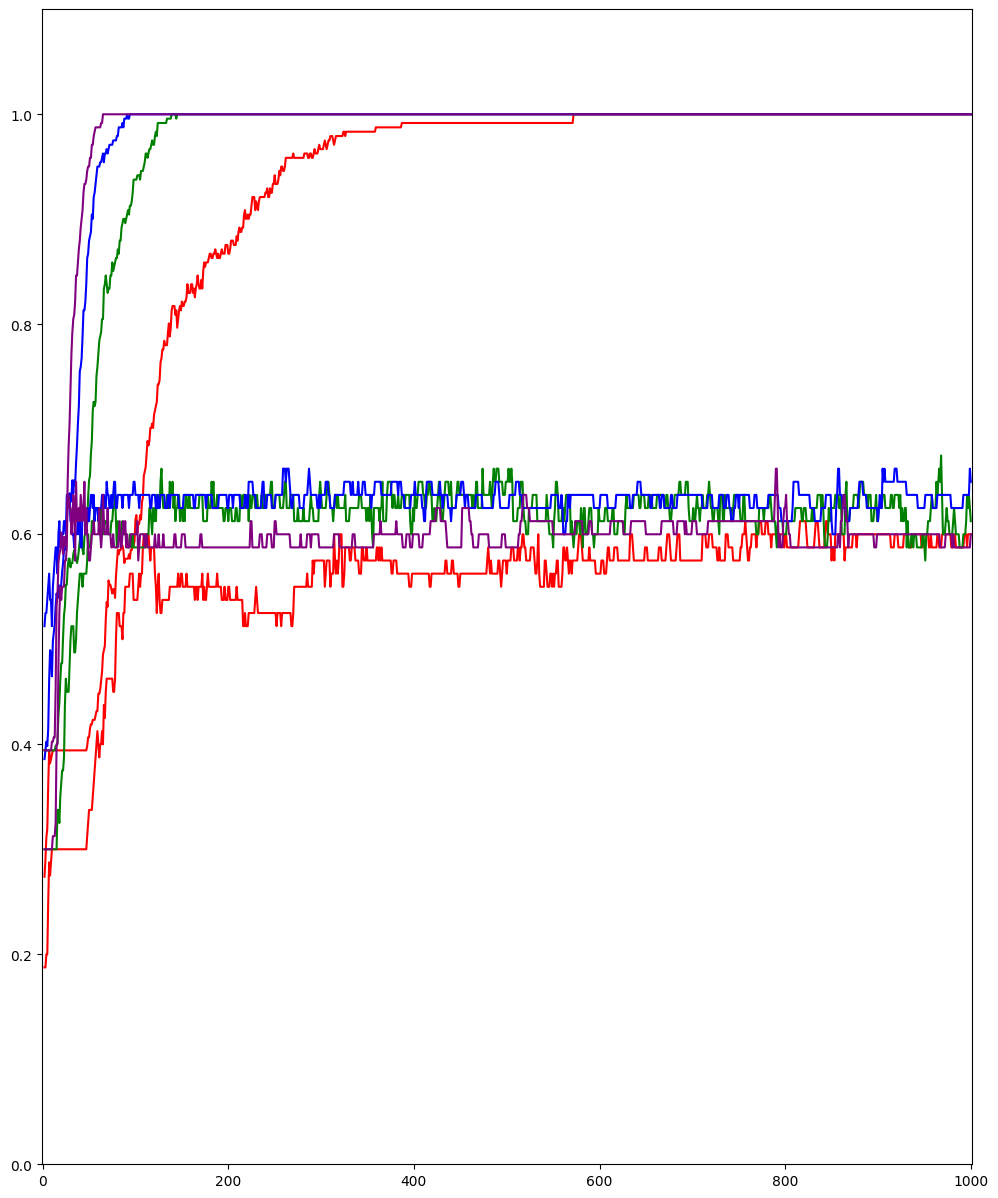

In [692]:

plt.figure(figsize=(12, 15))

plt.xlim(-1, 1001)  # X range [-1, 1001]
plt.ylim(0, 1.1)   

x = list(range(2,1001))

sns.lineplot(x=x, y=track_full[8][0],color='red')
sns.lineplot(x=x, y=track_full[8][1],color='red')

sns.lineplot(x=x, y=track_full[16][0],color='green')
sns.lineplot(x=x, y=track_full[16][1],color='green')

sns.lineplot(x=x, y=track_full[32][0],color='blue')
sns.lineplot(x=x, y=track_full[32][1],color='blue')

sns.lineplot(x=x, y=track_full[64][0],color='purple')
sns.lineplot(x=x, y=track_full[64][1],color='purple')

#plt.figure(figsize=(40, 80))


<AxesSubplot:>

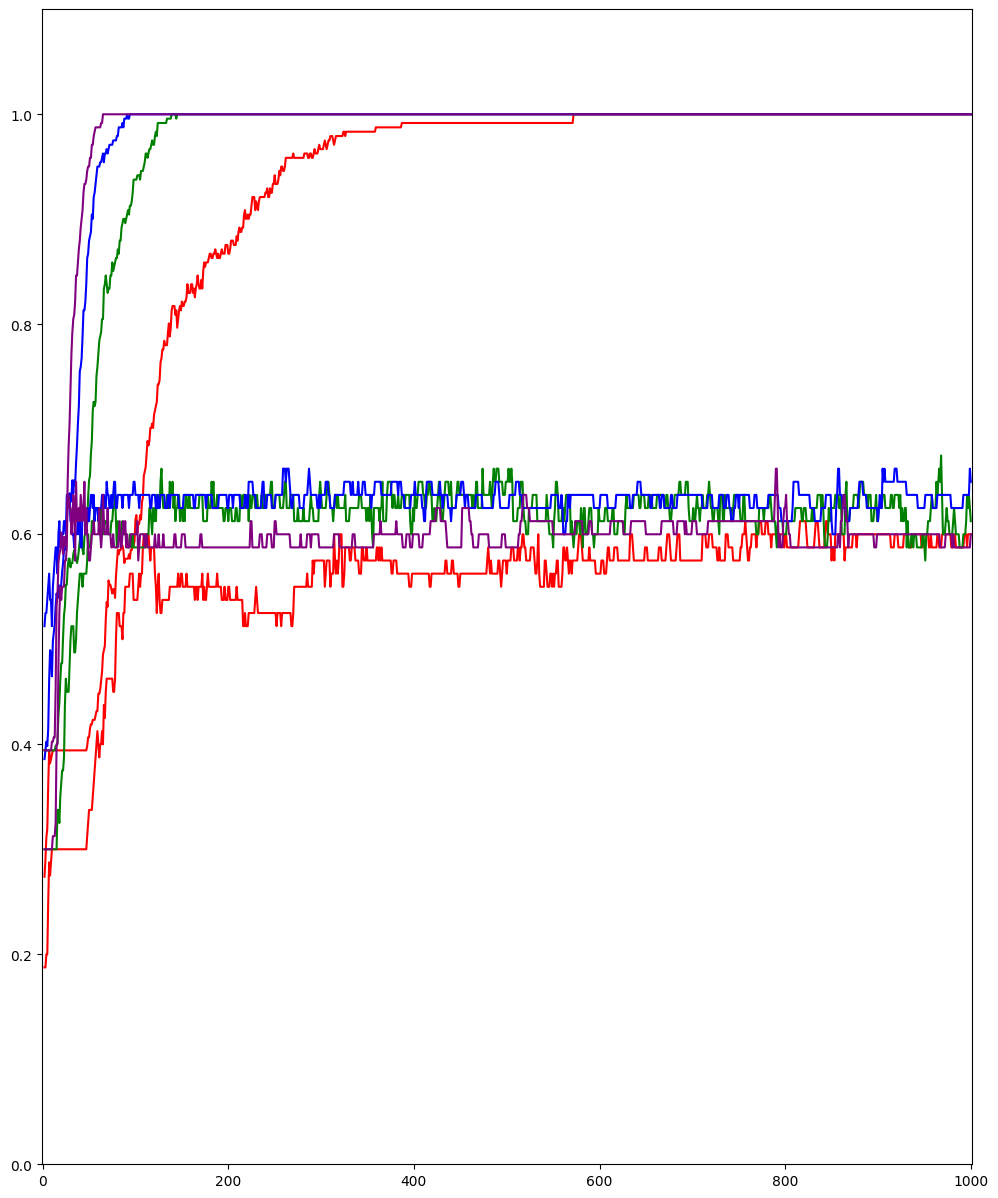

In [693]:
plt.figure(figsize=(12, 15))

plt.xlim(-1, 1001)  # X range [-1, 1001]
plt.ylim(0, 1.1)   

x = list(range(2,1001))

sns.lineplot(x=x, y=track[8][0],color='red')
sns.lineplot(x=x, y=track[8][1],color='red')

sns.lineplot(x=x, y=track[16][0],color='green')
sns.lineplot(x=x, y=track[16][1],color='green')

sns.lineplot(x=x, y=track[32][0],color='blue')
sns.lineplot(x=x, y=track[32][1],color='blue')

sns.lineplot(x=x, y=track[64][0],color='purple')
sns.lineplot(x=x, y=track[64][1],color='purple')


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

#### Take data from microbial. 

In [11]:
ann = glob.glob('/oak/stanford/groups/horence/punit/bioinformatics/results/*George_rerun_10*/bowtie*/Rfam_merge/merged_final.tsv')
fir = pd.read_csv(ann[0],sep='\t')
fir['dataset'] = ann[0]
for i in ann[1:]:
    nex = pd.read_csv(i,sep='\t')
    nex['dataset'] = i
    fir = pd.concat([fir,nex])
fir['GH_CRISPR'] = (fir['sequence_hits_spacers'] != '*') | (fir['sequence_hits_direct_repeats'] != '*')
fir['GH_MGE'] = (fir['sequence_hits_dfam_te_eukaryota'] != '*') | (fir['sequence_hits_ice_iceberg'] != '*') | (fir['sequence_hits_mge_aclame_genes_all_0'] != '*') | (fir['sequence_hits_tncentral_te_prokaryotes_final'] != '*')
fir['GH_positive'] = (fir['GH_CRISPR'] * 1) + (fir['GH_MGE'] * 1)
l = fir.groupby(['dataset','GH_CRISPR'])['anchor'].nunique().reset_index().rename(columns={'anchor':'CRISPR_anchs'})
r = fir.groupby(['dataset','GH_MGE'])['anchor'].nunique().reset_index().rename(columns={'anchor':'MGE_anchs'})
l[['GH_MGE','MGE_anchs']] = r[['GH_MGE','MGE_anchs']] 
l.loc[16]['dataset']

#### Ok, we're picking V. cholerae.

In [41]:
os.mkdir('vibrio_satc')
v = fir[fir['dataset']==l.loc[16]['dataset']].reset_index(drop=True)
cat = []
for i in range(len(v)):
    if v['GH_CRISPR'][i]: 
        cat.append("CRISPR")
    elif v['GH_MGE'][i]:
        cat.append("MGE")
    else:
        cat.append("unclassified")
v['class'] = cat
v[['anchor']].to_csv('vibrio_satc/anchor_list.txt',sep='\t',index=None,header=None)
satcs = glob.glob('/oak/stanford/groups/horence/punit/bioinformatics/results/vibrio_cholerae_v2.0.3_10_targets_George_rerun_10302023/kmc-nomad/result_satc/*')

for i in satcs:
    
    command = '/oak/stanford/groups/horence/george/splash_2.3.0/satc_dump --anchor_list vibrio_satc/anchor_list.txt '+str(i)+' vibrio_satc/'+i.split('/')[-1]
    os.system(command)
satcs = glob.glob('vibrio_satc/*bin*')
satc = pd.read_csv(satcs[0],sep='\t',header=None)
for i in satcs[1:]:
    satc = pd.concat([satc,pd.read_csv(i,sep='\t',header=None)])
satc = satc.rename(columns={0:'sample',1:'anchor',2:'target',3:'count'})
select = satc[satc['anchor']=='TAAGCTTCAACACTTTACATTTGAACC']

In [ ]:
construct_graph(data, graphName, nodeType, nodeFeatures, edgeFeatures, connectedness, ordering):
